<a href="https://colab.research.google.com/github/carlosruedap/capstone/blob/main/U_Net_Cell_Counting_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

# Define la ruta a tu carpeta
ruta_carpeta = '/content/drive/MyDrive/SIC/Capstone/U_NET'

# Lista todos los archivos y subcarpetas dentro de la carpeta
for elemento in os.listdir(ruta_carpeta):
  ruta_elemento = os.path.join(ruta_carpeta, elemento)
  if os.path.isdir(ruta_elemento):
    print(f"Subcarpeta: {elemento}")

  else:
    print(f"Archivo: {elemento}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subcarpeta: data
Subcarpeta: masks
Subcarpeta: train_data
Subcarpeta: train_masks
Subcarpeta: validation_data
Subcarpeta: validation_masks
Archivo: unet_checkpoint_20.keras
Archivo: unet_checkpoint_22.keras
Archivo: unet_checkpoint_24.keras
Subcarpeta: checkpoints


In [ ]:
# Actualiza tensorflow
pip install --upgrade tensorflow

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
# Actualiza Keras
pip install -U keras

In [ ]:
# Librerias necesarias

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model



In [ ]:
import os
import shutil
import random
# Divide los datos en entrenamiento y validacion (data y masks)

# Define the paths
data_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/data'
masks_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/masks'

train_data_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/train_data'
train_masks_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/train_masks'
validation_data_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/validation_data'
validation_masks_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/validation_masks'

# Crea los directorios si no existen
for path in [train_data_path, train_masks_path, validation_data_path, validation_masks_path]:
    os.makedirs(path, exist_ok=True)

# lista todos los archivos en data y masks
data_files = sorted(os.listdir(data_path))
mask_files = sorted(os.listdir(masks_path))

# Se asegura que data y masks tienen la misma cantidad de archivos y nombres consistentes
assert len(data_files) == len(mask_files), "La cantidad de archivos en data y masks es diferente"
assert all(data_file.split('.')[0] == mask_file.split('.')[0] for data_file, mask_file in zip(data_files, mask_files)), "Los nombres no son consistentes"

# Mezcla los archivos para dividirlos de manera aleatoria
combined = list(zip(data_files, mask_files))
random.shuffle(combined)
data_files[:], mask_files[:] = zip(*combined)

# Define la proporcion de entrenamiento y validacion
split_ratio = 0.7
split_index = int(len(data_files) * split_ratio)

# Divide los datos
train_data_files = data_files[:split_index]
train_mask_files = mask_files[:split_index]
validation_data_files = data_files[split_index:]
validation_mask_files = mask_files[split_index:]

# Mueve los archivos a sus directorios correspondientes
for file in train_data_files:
    shutil.copy(os.path.join(data_path, file), os.path.join(train_data_path, file))

for file in train_mask_files:
    shutil.copy(os.path.join(masks_path, file), os.path.join(train_masks_path, file))

for file in validation_data_files:
    shutil.copy(os.path.join(data_path, file), os.path.join(validation_data_path, file))

for file in validation_mask_files:
    shutil.copy(os.path.join(masks_path, file), os.path.join(validation_masks_path, file))


KeyboardInterrupt: 

In [ ]:
# Subir las carpetas al content (El proceso de entrenamiento se optimiza significativamente)
import shutil
train_data_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/train_data'
train_masks_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/train_masks'
validation_data_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/validation_data'
validation_masks_path = '/content/drive/MyDrive/SIC/Capstone/U_NET/validation_masks'

# Copia la carpeta 'train_data' al directorio '/content/'
shutil.copytree(train_data_path, '/content/train_data')

# Copia la carpeta 'train_masks' al directorio '/content/'
shutil.copytree(train_masks_path, '/content/train_masks')

# Copia la carpeta 'validation_data' al directorio '/content/'
shutil.copytree(validation_data_path, '/content/validation_data')

# Copia la carpeta 'validation_masks' al directorio '/content/'
shutil.copytree(validation_masks_path, '/content/validation_masks')

print("Carpetas subidas exitosamente al entorno.")


FileExistsError: [Errno 17] File exists: '/content/train_data'

In [ ]:
# Arquitectura de la CNN - U-Net

# Bloques residuales
def residual_block(input_tensor, filters):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_tensor)
    # Normalización de los Batch
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    # Numero de filtros
    shortcut = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


# Bloques de atención
def attention_block(input_tensor, filters):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    attention_map = Conv2D(filters, (1, 1), activation='sigmoid')(x)
    x = Multiply()([x, attention_map])
    return x


def unet_model(input_size=(224, 224, 3)):
    # Capa de entrada
    inputs = Input(input_size)

    # Codificador (Contracting Path)

    # Los bloques residuales facilitan el entrenamiento mientras que el
    # MaxPooling2D reduce la resolución espacial de las características
    # y la capa de dropout ayuda a evitar sobreajuste.

    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = residual_block(p3, 512)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # c5 es el cuello de botella donde se encuentran las características
    # más abstractas.

    c5 = residual_block(p4, 1024)

    # Decodificador (Expansive Path)

    # Se restaura la resolución espacial de las características con la
    # convolución transpuesta y concatenaciones con las características
    # del codificador, mientras que los bloques de atención refinan las
    # características, ponderando su importancia en función de su
    # relevancia para la tarea de segmentación. Se utilizan también
    # capas de dropout para evitar el sobreajuste.

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = attention_block(u6, 512)
    c6 = Dropout(0.2)(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = attention_block(u7, 256)
    c7 = Dropout(0.2)(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = attention_block(u8, 128)
    c8 = Dropout(0.1)(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = attention_block(u9, 64)
    c9 = Dropout(0.1)(c9)

    # Una capa convolucional final con un filtro y activación sigmoide
    # que genera la máscara de segmentación, donde cada píxel tiene un valor
    # entre 0 y 1 que indica la probabilidad de pertenecer a una colonia.

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=tf.keras.losses.Dice(), metrics=['accuracy'])
    return model


model = unet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 224, 224, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 224, 224, 64)   │            256 │ conv2d_84[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 224, 224, 64)   │            256 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 224, 224, 64)   │              0 │ conv2d_85[0][0],       │
│                           │                        │                │ conv2d_86[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 224, 224, 64)   │              0 │ add_15[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 112, 112, 64)   │              0 │ activation_15[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 112, 112, 64)   │              0 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 112, 112, 128)  │            512 │ conv2d_87[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 112, 112, 128)  │          8,320 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 112, 112, 128)  │              0 │ conv2d_88[0][0],       │
│                           │                        │                │ conv2d_89[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 112, 112, 128)  │              0 │ add_16[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13     

 Total params: 32,091,137 (122.42 MB)

 Trainable params: 32,085,249 (122.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
import tensorflow.keras as keras
import albumentations as A
from PIL import Image
import cv2

# Dada la naturaleza de los datos y la presencia de una sola clase, es
# preferible definir un generador de datos personalizado, que, durante
# el entrenamiento ofrezca la posibilidad de utilizar data augmentation
# para mejorar la generalizacion del modelo creando nuevas imágenes con
# rotaciones aleatorias, cambios de contraste y deformaciones.
# Esto aplica a las imagenes de entrada y sus respectivas máscaras.

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size=32, image_size=(224, 224), augmentation=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentation = augmentation

        self.images = os.listdir(images_path)
        self.masks = os.listdir(masks_path)

        # ImageDataGenerator para aumento de datos (si augmentation es True)
        if augmentation:
            self.image_datagen = ImageDataGenerator(
                rotation_range=90,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest'
            )
        else:
            self.image_datagen = ImageDataGenerator()  # Sin aumento

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        images = []
        masks = []
        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            image_path = os.path.join(self.images_path, self.images[i])
            mask_path = os.path.join(self.masks_path, self.masks[i])
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size)
            images.append(image)
            masks.append(mask)

        # Aplica aumento de datos (si augmentation es True)
        if self.augmentation:
            images, masks = self.augment_data(images, masks)

        # Convierte las listas a arrays para normalizar
        images = np.array(images)
        masks = np.array(masks)

        # Normaliza las imágenes
        images = images / 255.0
        masks = masks / 255.0
        masks = np.expand_dims(masks, axis=-1)

        return images, masks

    def augment_data(self, images, masks):
        transform = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ])

        augmented_images = []
        augmented_masks = []
        for img, msk in zip(images, masks):
            augmented = transform(image=img, mask=msk)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])

        return augmented_images, augmented_masks

In [ ]:
# Parámetros de entrenamiento ajustados para usar un acelerador de
# hardware L4 GPU

batch_size = 32
epochs = 50
learning_rate = 1e-4

# Se crean los generadores de datos sin data augmentation para la
# validación de los datos

train_generator = CustomDataGenerator(train_data_path, train_masks_path, batch_size=batch_size, augmentation=True)
validation_generator = CustomDataGenerator(validation_data_path, validation_masks_path, batch_size=batch_size, augmentation=False)

# Se compila el modelo

model.compile(optimizer=Adam(learning_rate=learning_rate), loss=binary_crossentropy, metrics=['accuracy'])

# Se usa callback para guardar checkpoints

checkpoint_callback = ModelCheckpoint(
    filepath="unet_checkpoint_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=True,
    monitor="val_loss",
    verbose=1
)

# Define el TensorBoard callback
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint_callback, tensorboard_callback]
)


		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 710ms/step - accuracy: 0.8608 - loss: 0.3263
		Epoch 1: val_loss improved from inf to 0.42075, saving model to unet_checkpoint_01.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m183s[0m 1s/step - accuracy: 0.8620 - loss: 0.3239 - val_accuracy: 0.9846 - val_loss: 0.4207
		Epoch 2/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 710ms/step - accuracy: 0.9861 - loss: 0.0415
		Epoch 2: val_loss improved from 0.42075 to 0.09050, saving model to unet_checkpoint_02.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 835ms/step - accuracy: 0.9861 - loss: 0.0415 - val_accuracy: 0.9846 - val_loss: 0.0905
		Epoch 3/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9884 - loss: 0.0317
		Epoch 3: val_loss improved from 0.09050 to 0.06506, saving model to unet_checkpoint_03.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 840ms/step - accuracy: 0.9884 - loss: 0.0317 - val_accuracy: 0.9846 - val_loss: 0.0651
		Epoch 4/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9888 - loss: 0.0298
		Epoch 4: val_loss did not improve from 0.06506
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 807ms/step - accuracy: 0.9888 - loss: 0.0298 - val_accuracy: 0.9846 - val_loss: 0.0664
		Epoch 5/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 707ms/step - accuracy: 0.9893 - loss: 0.0271
		Epoch 5: val_loss improved from 0.06506 to 0.05467, saving model to unet_checkpoint_05.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 835ms/step - accuracy: 0.9893 - loss: 0.0271 - val_accuracy: 0.9851 - val_loss: 0.0547
		Epoch 6/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 711ms/step - accuracy: 0.9896 - loss: 0.0263
		Epoch 6: val_loss improved from 0.05467 to 0.04530, saving model to unet_checkpoint_06.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 838ms/step - accuracy: 0.9896 - loss: 0.0263 - val_accuracy: 0.9854 - val_loss: 0.0453
		Epoch 7/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9896 - loss: 0.0257
		Epoch 7: val_loss did not improve from 0.04530
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m59s[0m 808ms/step - accuracy: 0.9896 - loss: 0.0257 - val_accuracy: 0.9853 - val_loss: 0.0525
		Epoch 8/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9898 - loss: 0.0259
		Epoch 8: val_loss improved from 0.04530 to 0.02985, saving model to unet_checkpoint_08.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 833ms/step - accuracy: 0.9898 - loss: 0.0259 - val_accuracy: 0.9887 - val_loss: 0.0299
		Epoch 9/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 710ms/step - accuracy: 0.9901 - loss: 0.0246
		Epoch 9: val_loss improved from 0.02985 to 0.02812, saving model to unet_checkpoint_09.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 835ms/step - accuracy: 0.9901 - loss: 0.0246 - val_accuracy: 0.9898 - val_loss: 0.0281
		Epoch 10/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9904 - loss: 0.0231
		Epoch 10: val_loss improved from 0.02812 to 0.02334, saving model to unet_checkpoint_10.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 835ms/step - accuracy: 0.9904 - loss: 0.0231 - val_accuracy: 0.9906 - val_loss: 0.0233
		Epoch 11/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9902 - loss: 0.0238
		Epoch 11: val_loss improved from 0.02334 to 0.01943, saving model to unet_checkpoint_11.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 838ms/step - accuracy: 0.9902 - loss: 0.0238 - val_accuracy: 0.9916 - val_loss: 0.0194
		Epoch 12/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9912 - loss: 0.0213
		Epoch 12: val_loss did not improve from 0.01943
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 804ms/step - accuracy: 0.9912 - loss: 0.0214 - val_accuracy: 0.9915 - val_loss: 0.0195
		Epoch 13/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9904 - loss: 0.0230
		Epoch 13: val_loss improved from 0.01943 to 0.01797, saving model to unet_checkpoint_13.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 833ms/step - accuracy: 0.9904 - loss: 0.0230 - val_accuracy: 0.9920 - val_loss: 0.0180
		Epoch 14/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9905 - loss: 0.0226
		Epoch 14: val_loss did not improve from 0.01797
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 804ms/step - accuracy: 0.9905 - loss: 0.0226 - val_accuracy: 0.9915 - val_loss: 0.0208
		Epoch 15/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9908 - loss: 0.0212
		Epoch 15: val_loss did not improve from 0.01797
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 808ms/step - accuracy: 0.9908 - loss: 0.0212 - val_accuracy: 0.9911 - val_loss: 0.0200
		Epoch 16/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9910 - loss: 0.0204
		Epoch 16: val_loss improved from 0.01797 to 0.01723, saving model to unet_checkpoint_16.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 836ms/step - accuracy: 0.9910 - loss: 0.0205 - val_accuracy: 0.9923 - val_loss: 0.0172
		Epoch 17/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9909 - loss: 0.0208
		Epoch 17: val_loss did not improve from 0.01723
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 809ms/step - accuracy: 0.9909 - loss: 0.0208 - val_accuracy: 0.9920 - val_loss: 0.0180
		Epoch 18/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9905 - loss: 0.0217
		Epoch 18: val_loss improved from 0.01723 to 0.01677, saving model to unet_checkpoint_18.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 833ms/step - accuracy: 0.9905 - loss: 0.0217 - val_accuracy: 0.9923 - val_loss: 0.0168
		Epoch 19/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9912 - loss: 0.0194
		Epoch 19: val_loss did not improve from 0.01677
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 807ms/step - accuracy: 0.9912 - loss: 0.0194 - val_accuracy: 0.9915 - val_loss: 0.0189
		Epoch 20/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 707ms/step - accuracy: 0.9913 - loss: 0.0195
		Epoch 20: val_loss did not improve from 0.01677
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 803ms/step - accuracy: 0.9913 - loss: 0.0195 - val_accuracy: 0.9918 - val_loss: 0.0176
		Epoch 21/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9917 - loss: 0.0182
		Epoch 21: val_loss did not improve from 0.01677
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 809ms/step - accuracy: 0.9916 - loss: 0.0183 - val_accuracy: 0.9917 - val_loss: 0.0176
		Epoch 22/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9907 - loss: 0.0203
		Epoch 22: val_loss did not improve from 0.01677
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 807ms/step - accuracy: 0.9907 - loss: 0.0203 - val_accuracy: 0.9918 - val_loss: 0.0179
		Epoch 23/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9913 - loss: 0.0188
		Epoch 23: val_loss improved from 0.01677 to 0.01670, saving model to unet_checkpoint_23.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 836ms/step - accuracy: 0.9913 - loss: 0.0188 - val_accuracy: 0.9923 - val_loss: 0.0167
		Epoch 24/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9920 - loss: 0.0172
		Epoch 24: val_loss improved from 0.01670 to 0.01563, saving model to unet_checkpoint_24.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 835ms/step - accuracy: 0.9920 - loss: 0.0172 - val_accuracy: 0.9924 - val_loss: 0.0156
		Epoch 25/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9913 - loss: 0.0188
		Epoch 25: val_loss did not improve from 0.01563
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 806ms/step - accuracy: 0.9913 - loss: 0.0188 - val_accuracy: 0.9918 - val_loss: 0.0174
		Epoch 26/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9915 - loss: 0.0185
		Epoch 26: val_loss did not improve from 0.01563
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 807ms/step - accuracy: 0.9915 - loss: 0.0185 - val_accuracy: 0.9924 - val_loss: 0.0157
		Epoch 27/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9917 - loss: 0.0178
		Epoch 27: val_loss did not improve from 0.01563
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 807ms/step - accuracy: 0.9917 - loss: 0.0178 - val_accuracy: 0.9925 - val_loss: 0.0157
		Epoch 28/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9919 - loss: 0.0170
		Epoch 28: val_loss did not improve from 0.01563
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 806ms/step - accuracy: 0.9919 - loss: 0.0170 - val_accuracy: 0.9925 - val_loss: 0.0157
		Epoch 29/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 709ms/step - accuracy: 0.9921 - loss: 0.0168
		Epoch 29: val_loss improved from 0.01563 to 0.01529, saving model to unet_checkpoint_29.keras
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m60s[0m 838ms/step - accuracy: 0.9921 - loss: 0.0168 - val_accuracy: 0.9925 - val_loss: 0.0153
		Epoch 30/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9915 - loss: 0.0180
		Epoch 30: val_loss did not improve from 0.01529
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 805ms/step - accuracy: 0.9915 - loss: 0.0180 - val_accuracy: 0.9925 - val_loss: 0.0157
		Epoch 31/50
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 708ms/step - accuracy: 0.9919 - loss: 0.0170
		Epoch 31: val_loss did not improve from 0.01529
		[1m69/69[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m58s[0m 811ms/step - accuracy: 0.9919 - loss: 0.0170 - val_accuracy: 0.9919 - val_loss: 0.0177
		Epoch 32/50
		[1m15/69[0m [32m━━━━[0m[37m━━━━━━━━━━━━━━━━[0m [1m38s[0m 707ms/step - accuracy: 0.9921 - loss: 0.0163


In [ ]:
# Cargar el mejor modelo guardado

from tensorflow.keras.models import load_model # Import the load_model function
from sklearn.metrics import jaccard_score
from tensorflow.keras import backend as K # Import the Keras backend

model = load_model('unet_checkpoint_24.keras', compile=False) # No compilar el modelo al cargarlo

# Crear los generadores de datos (sin aumento en validación)
train_generator = CustomDataGenerator(train_data_path, train_masks_path, batch_size=32, augmentation=True)
validation_generator = CustomDataGenerator(validation_data_path, validation_masks_path, batch_size=32, augmentation=False)

def dice_coef(y_true, y_pred):
    smooth = K.constant(1.0)  # No change here
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (K.constant(2.0) * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) # Change 2.0 to K.constant(2.0)

# Evaluar el modelo en el conjunto de validación
y_pred = []
y_true = []
for i in range(len(validation_generator)):
    x_val, y_val = validation_generator[i]
    y_pred.append(model.predict(x_val))
    y_true.append(y_val)

# Concatenate and threshold predictions (modified)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred_thresholded = tf.cast((y_pred > 0.5), tf.int64) # Convert to TensorFlow tensor
y_true_thresholded = tf.cast((y_true > 0.5), tf.int64) # Convert to TensorFlow tensor



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
# prompt: necesito calcular las metricas de rendimiento

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Aplanar las predicciones y las etiquetas verdaderas
y_pred_flat = y_pred_thresholded.numpy().flatten()
y_true_flat = y_true_thresholded.numpy().flatten()

# Calcular las métricas
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
jaccard = jaccard_score(y_true_flat, y_pred_flat)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Jaccard Index:", jaccard)


Accuracy: 0.9939214333194215
Precision: 0.8286546259641185
Recall: 0.7165677748961441
F1-score: 0.7685459402529102
Jaccard Index: 0.6240963145720195


In [ ]:
# Dice coef
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    smooth = K.constant(1.0)
    y_true_f = K.flatten(K.cast(y_true, 'float32')) # Cast to float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32')) # Cast to float32
    intersection = K.sum(y_true_f * y_pred_f)
    return (K.constant(2.0) * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Assuming y_true and y_pred are your ground truth and predicted masks
dice_score = dice_coef(y_true_thresholded, y_pred_thresholded).numpy()
print("Dice Coefficient:", dice_score)


Dice Coefficient: 0.7685463


In [ ]:
# Guardar el modelo
save_model(model, 'unet_model.keras')


In [ ]:
# prompt: Sube este archivo a mi drive

!cp /content/unet_model.keras /content/drive/MyDrive/


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


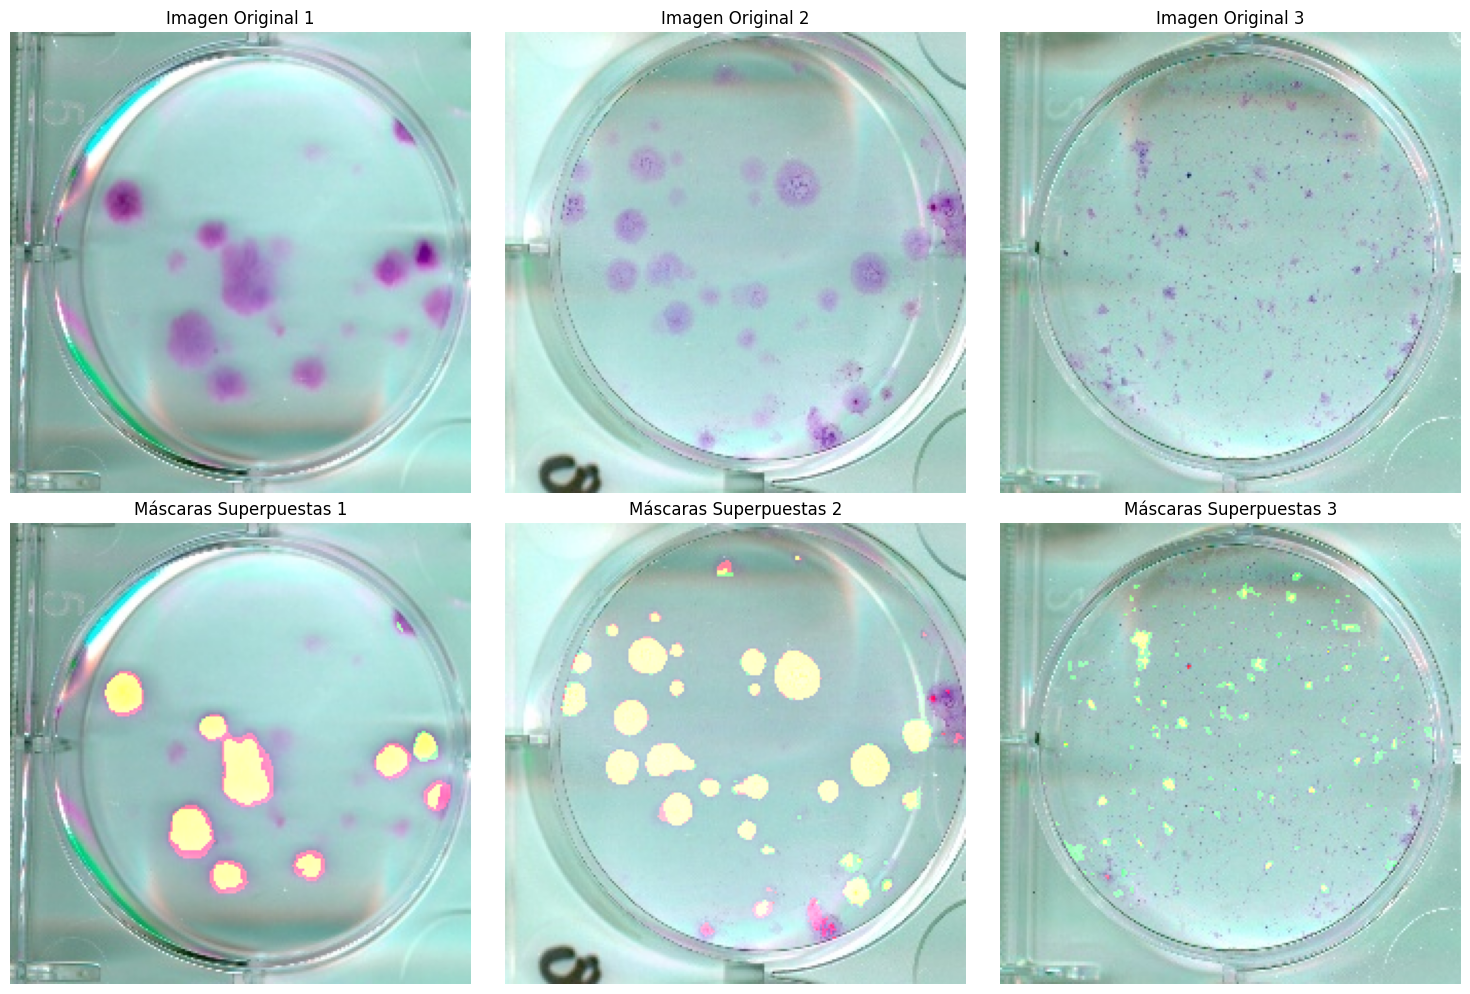

In [ ]:
# Importar las librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Cargar el modelo (una sola vez)
model = load_model('unet_model.keras')

# Lista de rutas a tus imágenes y sus máscaras correspondientes
image_paths = [
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image6_seg_1_1_rt_90.jpg',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image20_seg_1_1_rt_90.jpg',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image2_seg_1_1_rt_90.jpg'
]

mask_paths = [
    '/content/drive/MyDrive/SIC/Capstone/U_NET/masks/image6_seg_1_1_rt_90.png',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/masks/image20_seg_1_1_rt_90.png',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/masks/image2_seg_1_1_rt_90.png'
]

# Tamaño de entrada del modelo
input_size = (224, 224)

# Umbral para la máscara
threshold = 0.5

# Función para procesar una imagen
def process_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, input_size)
    image_norm = image / 255.0
    image_input = np.expand_dims(image_norm, axis=0)

    prediction = model.predict(image_input)[0, :, :, 0]
    mask = (prediction > threshold).astype(np.uint8)

    red_mask = np.zeros((*input_size, 4), dtype=np.uint8)
    red_mask[mask == 1] = [255, 0, 0, 127]  # Máscara predicha en rojo

    return image, red_mask

# Función para cargar y procesar una máscara original
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, input_size)
    mask_binary = (mask > threshold * 255).astype(np.uint8)  # Binaria
    green_mask = np.zeros((*input_size, 4), dtype=np.uint8)
    green_mask[mask_binary == 1] = [0, 255, 0, 127]  # Máscara original en verde

    return green_mask

# Procesamiento y visualización
plt.figure(figsize=(15, 10))  # Ajusta el tamaño de la figura
for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    image, pred_mask = process_image(image_path)
    original_mask = load_mask(mask_path)

    # Superponer ambas máscaras sobre la imagen original
    image_rgba = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    blended_image = cv2.add(cv2.add(image_rgba, original_mask), pred_mask)

    plt.subplot(2, 3, i + 1)  # Subplots en la primera fila para las imágenes originales
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Imagen Original {i + 1}')
    plt.axis('off')

    plt.subplot(2, 3, i + 4)  # Subplots en la segunda fila para las imágenes con ambas máscaras superpuestas
    plt.imshow(blended_image)
    plt.title(f'Máscaras Superpuestas {i + 1}')
    plt.axis('off')

plt.tight_layout()  # Ajusta los parámetros de los subplots para que los subplots se ajusten en el área de la figura
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


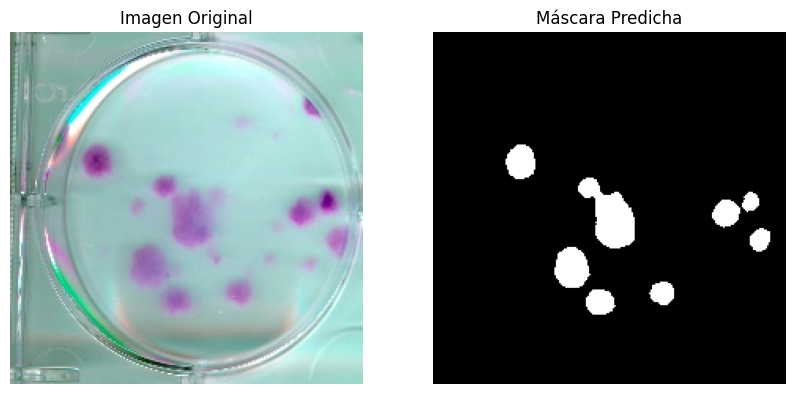

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


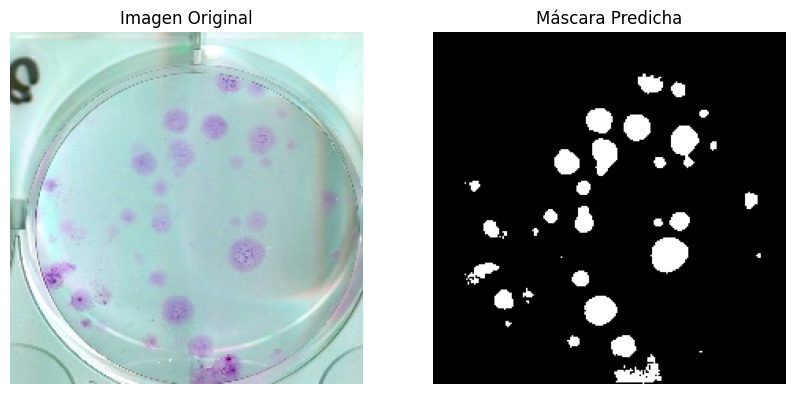

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


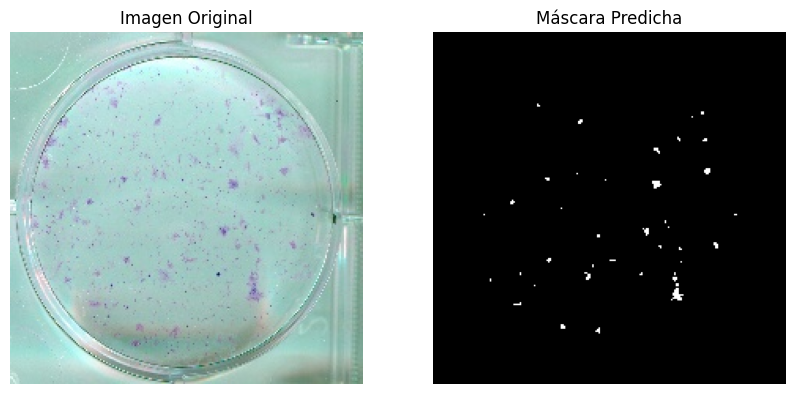

In [ ]:
# prompt: necesito predecir y que me muestre la mascara predicha y que la guarde en drive

# Importar las librerías necesarias
from google.colab import drive
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cargar el modelo (una sola vez)
model = load_model('unet_model.keras')

# Lista de rutas a tus imágenes
image_paths = [
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image6_seg_1_1_rt_90.jpg',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image20_seg_1_1_rt_180.jpg',
    '/content/drive/MyDrive/SIC/Capstone/U_NET/data/image2_seg_1_1_rt_270.jpg'
]

# Tamaño de entrada del modelo
input_size = (224, 224)

# Umbral para la máscara
threshold = 0.5

# Directorio en Drive para guardar las máscaras predichas
output_directory = '/content/drive/MyDrive/SIC/Capstone/U_NET/predicted_masks/'
os.makedirs(output_directory, exist_ok=True)

# Función para procesar una imagen y guardar la máscara predicha
def process_and_save_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, input_size)
    image_norm = image / 255.0
    image_input = np.expand_dims(image_norm, axis=0)

    prediction = model.predict(image_input)[0, :, :, 0]
    mask = (prediction > threshold).astype(np.uint8) * 255  # Multiplica por 255 para tener valores de 0 a 255

    # Nombre del archivo de salida
    output_filename = os.path.join(output_directory, os.path.basename(image_path).replace('.jpg', '_mask.png'))

    # Guardar la máscara predicha
    cv2.imwrite(output_filename, mask)

    # Visualizar la imagen original y la máscara predicha
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara Predicha')
    plt.axis('off')

    plt.show()

# Procesar cada imagen y guardar su máscara predicha
for image_path in image_paths:
    process_and_save_image(image_path)
